# Try to classify contigs as prokaryotic or eukaryotic just from an alignment

General idea: eukaryotic contigs, compared with prokaryotic contigs, should have relatively high amounts of positions with variants around 50% frequency (representing diploidy).

In [1]:
%run "Header.ipynb"

In [2]:
import math
import json
import time
import skbio
import pysam
import pysamstats

In [3]:
# No edges with length < this will be considered here
MIN_SEQ_LEN = 5000

MIN_COV = 10

# "A position is classified as well-covered if its coverage differs from
# the contig's average coverage by at most deviation percent (using a
# default value of deviation = 20%)."
COV_DEVIATION = 0.2

# Both of these are inclusive.
MIN_DIPLOID_MAXALT_FREQ = 0.4
MIN_DENOMINATOR_MAXALT_FREQ = 0.05

In [4]:
def get_mutation_freq(rec, verbose=False):
    """rec is a pysamstats record for a given position in the alignment produced by stat_variation().
    
    Returns a 3-tuple of (alt nt, alt nt freq, alt nt relfreq): (str, int, float).
    """
    
    cov = rec["matches"] + rec["mismatches"]
    
    # Figure out the maximum-frequency alternate nucleotide
    nonmatches = set("ACGT") - set(rec["ref"])
    ordered_alt_nts = sorted(nonmatches, key=rec.get)
    
    # The literal nucleotide used in the numerator of freq(pos): one of A, C, G, T
    alt_nt = ordered_alt_nts[-1]
    # The raw frequency (in counts) of the max_alt_nt. An integer >= 0.
    alt_nt_freq = rec[alt_nt]
    # The relative frequency (in counts) of the max_alt_nt. A float in the range [0, 1].
    alt_nt_relfreq = alt_nt_freq / cov

    if verbose: print(f"\tMax freq alt nt: {alt_nt}. Freq = {alt_nt_freq:,}.")

    # Redefine freq(pos) so that it's always in [0%, 50%]. So, if the max-freq alt nucleotide is also the
    # consensus nucleotide, redefine this.
    if alt_nt_relfreq > 0.5:
        
        # Consider a different set of nucleotides: "ACGT" minus the max-freq alt nt, which has
        # relative frequency above 50% (i.e. it's the consensus nucleotide, even though it isn't
        # the reference). We consider the second-most-common alternate nucleotide, then -- and this
        # could even be the reference nucleotide.
        non_alt1_nts = set("ACGT") - set(alt_nt)
        ordered_nts = sorted(non_alt1_nts, key=rec.get)
        
        # Redefine variables from before
        alt_nt = ordered_nts[-1]
        alt_nt_freq = rec[alt_nt]
        alt_nt_relfreq = alt_nt_freq / cov
        if verbose: print(f"\tRedefined freq(pos) to be <= 50%. alt2 = {alt_nt}. Freq = {alt_nt_freq:,}.")

    return (alt_nt, alt_nt_freq, alt_nt_relfreq)

## Get a mapping of sequence (edge) name to sequence length

stolen from the diversity index notebook; should merge these into a single function

also the div index notebook version of this accidentally trumps the `seq2len` variable defined in the header notebook... should fix that, but not super impt

In [5]:
edge2len = {}
edgename = None
with open("../main-workflow/output/all_edges.fasta", "r") as fastafile:
    
    # Assumes that sequences are not split up over multiple lines (so a FASTA file with N sequences
    # should have only 2N lines, maybe 2N + 1 if there's an extra empty newline at the bottom of the file)
    for linenum, line in enumerate(fastafile):
    
        if line.startswith(">"):
            if linenum % 2 != 0:
                raise ValueError("something weird with > location in all_edges.fasta. Go yell at Marcus.")
            edgename = line.strip()[1:]
        else:
            if linenum % 2 != 1:
                raise ValueError("something weird with non > location in all_edges.fasta. Go yell at Marcus.")
            if edgename is None:
                raise ValueError("No sequence name set yet?")
            edge2len[edgename] = len(line.strip())
            edgename = None

print(f"edge2len contains {len(edge2len):,} entries. The length of edge_1 is {edge2len['edge_1']:,} bp.")

edge2len contains 78,793 entries. The length of edge_1 is 39,565 bp.


In [6]:
long_enough_seqs = []
for edge in edge2len:
    if edge2len[edge] >= MIN_SEQ_LEN:
        long_enough_seqs.append(edge)
        
pct = 100 * (len(long_enough_seqs) / len(edge2len))
print(f"{len(long_enough_seqs):,} / {len(edge2len):,} ({pct:.2f}%) edges have a length of at least {MIN_SEQ_LEN:,.0f} bp.")

43,562 / 78,793 (55.29%) edges have a length of at least 5,000 bp.


## Load edge2meancov

We kind of assume this has already been computed

In [7]:
with open("misc-output/prok-euk-info.txt", "r") as pef:
    for linenum, line in enumerate(pef, 1):
        if linenum == 5:
            edge2meancov = json.loads(line.strip())

In [8]:
print(f"edge2meancov has {len(edge2meancov):,} entries.")

edge2meancov has 43,562 entries.


## Go through the alignment; count well-covered and "diploid" positions

Parts of this (e.g. processing each record in the pileup) could be abstracted to code that's shared between here, the diversity index ntbk, and the bam2pileup script I wrote for the three "selected" MAGs.

**NOTE: This takes quite a while to run (as of writing, it took about 18.4 hours to complete).**

In [19]:
bf = pysam.AlignmentFile("../main-workflow/output/fully-filtered-and-sorted-aln.bam", "rb")

In [ ]:
edge2num_wc_pos = {}
edge2num_wc_diploid_pos = {}
edge2num_wc_den_pos = {}

num_seqs = len(long_enough_seqs)

# This'll print out a ton of output for even a single contig, so I don't recommend using this in practice.
# It's useful if you just want to only focus on a single contig while debugging, though.
verbose = False

t1 = time.time()

for si, seq in enumerate(long_enough_seqs, 1):
    pct = 100 * (si / num_seqs)
    meancov = edge2meancov[seq]
    print(f"On seq {seq} ({si:,} / {num_seqs:,}) ({pct:.2f}%).", end=" ", flush=True)   
    print(f"{edge2len[seq]:,} bp long. meancov = {meancov:,.2f}x.", end=" ", flush=True)
    print(f"Runtime: ~{time.time() - t1:,.0f} sec.", end=" ", flush=True)
    
    one_tenth_len = math.floor(edge2len[seq] / 10)
    
    num_wc_pos = 0
    num_wc_diploid_pos = 0
    num_wc_den_pos = 0
    
    min_wc_cov = max(meancov - (meancov * COV_DEVIATION), 1)
    
    # Go through each position in the sequence's pileup (even including relatively low-coverage positions).
    # See bam-to-jsons.py for a description of why these params are useful.
    # Also, note that pysam coords are 0-indexed!
    for ri, rec in enumerate(
        pysamstats.stat_variation(
            bf, chrom=seq, fafile="../main-workflow/output/all_edges.fasta", start=0, end=edge2len[seq],
            truncate=True, pad=True, max_depth=1e6
        ),
        1
    ):
        # very simple progress bar for my own sake. might miss a few dots here and there
        if ri % one_tenth_len == 0:
            print("=", end="", flush=True)
            
        matches = rec["matches"]
        mismatches = rec["mismatches"]
        # NOTE: As with "coverage" in the coverage plots, this doesn't take into account deletions at a
        # given position. That info is available through pysamstats so we could use it here if desired.
        cov = matches + mismatches
                
        if verbose: print(f"Pos {ri}... Matches: {matches} / Mismatches: {mismatches} / cov: {cov}")
        
        if cov >= min_wc_cov:
            num_wc_pos += 1
            
            alt_nt, alt_nt_freq, alt_nt_relfreq = get_mutation_freq(rec, verbose=verbose)
            
            # The meat of this: see if this position "counts" as putatively diploid
            if alt_nt_relfreq >= MIN_DIPLOID_MAXALT_FREQ:
                num_wc_diploid_pos += 1
                if verbose: print(f"\tPutatively diploid! rel freq = {alt_nt_relfreq}")
                
            # Count, less generally, positions in a broader range -- we'll use this as the denominator
            if alt_nt_relfreq >= MIN_DENOMINATOR_MAXALT_FREQ and alt_nt_freq > 1:
                num_wc_den_pos += 1
                if verbose: print(f"\tPosition {ri} has a mut rate >= 5%: {alt_nt_freq} / {cov} = {alt_nt_relfreq}")

    assert ri == edge2len[seq]
    
    # Save info for each edge
    edge2num_wc_pos[seq] = num_wc_pos
    edge2num_wc_diploid_pos[seq] = num_wc_diploid_pos
    edge2num_wc_den_pos[seq] = num_wc_den_pos

    # Move print info to a new line
    print(f"\n\t{num_wc_pos:,} WCP;", end=" ")
    print(f"{num_wc_diploid_pos:,} 'diploid' WCP;", end=" ")
    print(f"{num_wc_den_pos:,} 'denominator' WCP;", end=" ")
    print(f"min WC cov is set to {min_wc_cov:,.2f}x.")

On seq edge_1 (1 / 43,562) (0.00%). 39,565 bp long. meancov = 460.40x. Runtime: ~0 sec. ==========
	32,671 WCP; 6 'diploid' WCP; 245 'denominator' WCP; min WC cov is set to 368.32x.
On seq edge_3 (2 / 43,562) (0.00%). 38,161 bp long. meancov = 258.76x. Runtime: ~2 sec. ==========
	26,015 WCP; 11 'diploid' WCP; 257 'denominator' WCP; min WC cov is set to 207.01x.
On seq edge_5 (3 / 43,562) (0.01%). 32,079 bp long. meancov = 3.36x. Runtime: ~3 sec. ==========
	22,211 WCP; 139 'diploid' WCP; 177 'denominator' WCP; min WC cov is set to 2.69x.
On seq edge_6 (4 / 43,562) (0.01%). 6,738 bp long. meancov = 1.40x. Runtime: ~3 sec. ==========
	2,975 WCP; 0 'diploid' WCP; 0 'denominator' WCP; min WC cov is set to 1.12x.
On seq edge_8 (5 / 43,562) (0.01%). 1,710,962 bp long. meancov = 111.64x. Runtime: ~3 sec. ==========
	1,584,064 WCP; 0 'diploid' WCP; 1,889 'denominator' WCP; min WC cov is set to 89.31x.
On seq edge_9 (6 / 43,562) (0.01%). 91,227 bp long. meancov = 5.06x. Runtime: ~31 sec. =====

On seq edge_59 (46 / 43,562) (0.11%). 852,260 bp long. meancov = 6.05x. Runtime: ~268 sec. ==========
	599,190 WCP; 352 'diploid' WCP; 1,540 'denominator' WCP; min WC cov is set to 4.84x.
On seq edge_60 (47 / 43,562) (0.11%). 1,726,090 bp long. meancov = 243.86x. Runtime: ~277 sec. ==========
	933,381 WCP; 1 'diploid' WCP; 973 'denominator' WCP; min WC cov is set to 195.09x.
On seq edge_61 (48 / 43,562) (0.11%). 202,190 bp long. meancov = 5.54x. Runtime: ~314 sec. ==========
	140,980 WCP; 103 'diploid' WCP; 359 'denominator' WCP; min WC cov is set to 4.43x.
On seq edge_62 (49 / 43,562) (0.11%). 106,456 bp long. meancov = 3.05x. Runtime: ~317 sec. ==========
	65,162 WCP; 0 'diploid' WCP; 0 'denominator' WCP; min WC cov is set to 2.44x.
On seq edge_63 (50 / 43,562) (0.11%). 100,190 bp long. meancov = 6.21x. Runtime: ~318 sec. ==========
	69,879 WCP; 0 'diploid' WCP; 1 'denominator' WCP; min WC cov is set to 4.97x.
On seq edge_64 (51 / 43,562) (0.12%). 33,880 bp long. meancov = 2.49x. Run

On seq edge_111 (91 / 43,562) (0.21%). 254,125 bp long. meancov = 4.18x. Runtime: ~556 sec. ==========
	156,744 WCP; 18 'diploid' WCP; 79 'denominator' WCP; min WC cov is set to 3.34x.
On seq edge_112 (92 / 43,562) (0.21%). 14,745 bp long. meancov = 1.16x. Runtime: ~560 sec. ==========
	10,023 WCP; 0 'diploid' WCP; 0 'denominator' WCP; min WC cov is set to 1.00x.
On seq edge_113 (93 / 43,562) (0.21%). 616,026 bp long. meancov = 7.35x. Runtime: ~560 sec. ==========
	471,018 WCP; 3 'diploid' WCP; 1,173 'denominator' WCP; min WC cov is set to 5.88x.
On seq edge_118 (94 / 43,562) (0.22%). 174,081 bp long. meancov = 3.92x. Runtime: ~569 sec. ==========
	95,164 WCP; 0 'diploid' WCP; 0 'denominator' WCP; min WC cov is set to 3.14x.
On seq edge_120 (95 / 43,562) (0.22%). 60,659 bp long. meancov = 37.80x. Runtime: ~571 sec. ==========
	48,253 WCP; 0 'diploid' WCP; 128 'denominator' WCP; min WC cov is set to 30.24x.
On seq edge_121 (96 / 43,562) (0.22%). 178,335 bp long. meancov = 9.91x. Runtime

On seq edge_929 (179 / 43,562) (0.41%). 471,232 bp long. meancov = 27.15x. Runtime: ~1,146 sec. ==========
	201,650 WCP; 0 'diploid' WCP; 98 'denominator' WCP; min WC cov is set to 21.72x.
On seq edge_931 (180 / 43,562) (0.41%). 5,214 bp long. meancov = 0.00x. Runtime: ~1,153 sec. ==========
	0 WCP; 0 'diploid' WCP; 0 'denominator' WCP; min WC cov is set to 1.00x.
On seq edge_936 (181 / 43,562) (0.42%). 32,998 bp long. meancov = 3.61x. Runtime: ~1,153 sec. ==========
	25,096 WCP; 0 'diploid' WCP; 0 'denominator' WCP; min WC cov is set to 2.89x.
On seq edge_947 (182 / 43,562) (0.42%). 713,612 bp long. meancov = 58.96x. Runtime: ~1,154 sec. ==========
	448,325 WCP; 269 'diploid' WCP; 5,604 'denominator' WCP; min WC cov is set to 47.17x.
On seq edge_960 (183 / 43,562) (0.42%). 2,087,411 bp long. meancov = 15.04x. Runtime: ~1,165 sec. ==========
	1,484,637 WCP; 4,683 'diploid' WCP; 21,162 'denominator' WCP; min WC cov is set to 12.03x.
On seq edge_962 (184 / 43,562) (0.42%). 5,567 bp long.

### Save info to a file

Since this can take a few hours to compute, this helps if we have to restart the notebook halfway through / etc.

In [ ]:
with open("misc-output/prok-euk-info-2.txt", "w") as pef:
    pef.write(json.dumps(edge2num_wc_pos))
    pef.write("\n")
    pef.write(json.dumps(edge2num_wc_diploid_pos))
    pef.write("\n")
    pef.write(json.dumps(edge2num_wc_den_pos))
    pef.write("\n")

### Load info from that file (...) just in case we need to restart this notebook, or adjust the plotting without rerunning the above stuff

This is obviously a very _ad hoc_ way of defining a file format. If this ever becomes a tool people use, it'd be a lot faster / more efficient to store this in a dedicated table structure!

In [6]:
with open("misc-output/prok-euk-info-2.txt", "r") as pef:
    for linenum, line in enumerate(pef, 1):
        if linenum == 1:
            edge2num_wc_pos = json.loads(line.strip())
        elif linenum == 2:
            edge2num_wc_diploid_pos = json.loads(line.strip())
        elif linenum == 3:
            edge2num_wc_den_pos = json.loads(line.strip())

## Plot histograms of fractions of "diploid" positions across contigs

In [17]:
# TODO: make this code less ugly ._. Maybe make a utility function that automates some of this stuff?
edge2frac_diploid_to_mincov_positions = {}
edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch = {}
edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5 = {}
edge2frac_diploid_to_mincov_positions_in_denominator_range = {}
edge2frac_diploid_to_mincov_positions_in_denominator_range_only_if_den_geq5 = {}
for e in edge2meancov.keys():
    if edge2num_mincov_positions[e] > 0:
        edge2frac_diploid_to_mincov_positions[e] = (
            edge2num_mincov_putatively_diploid_positions[e] / edge2num_mincov_positions[e]
        )
        
    if edge2num_mincov_positions_with_at_least_one_mismatch[e] > 0:
        f = (
            edge2num_mincov_putatively_diploid_positions[e] / edge2num_mincov_positions_with_at_least_one_mismatch[e]
        )
        edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch[e] = f
        if edge2num_mincov_positions_with_at_least_one_mismatch[e] >= 5:
            edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5[e] = f
            
    if edge2num_mincov_positions_with_mutrate_in_denominator_range[e] > 0:
        f = (
            edge2num_mincov_putatively_diploid_positions[e] / edge2num_mincov_positions_with_mutrate_in_denominator_range[e]
        )
        edge2frac_diploid_to_mincov_positions_in_denominator_range[e] = f
        if edge2num_mincov_positions_with_mutrate_in_denominator_range[e] >= 5:
            edge2frac_diploid_to_mincov_positions_in_denominator_range_only_if_den_geq5[e] = f
            
print(f"{len(edge2meancov):,} unique edges that we considered above (with min len of >= {MIN_SEQ_LEN:,} bp).")
print(f"{len(edge2frac_diploid_to_mincov_positions):,} unique edges with > 0 min-cov positions.")
print(f"{len(edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch):,} unique edges with > 0 min-cov positions with at least one mismatch.")
print(f"{len(edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5):,} unique edges with  >= 5 min-cov positions with at least one mismatch.")
print(f"{len(edge2frac_diploid_to_mincov_positions_in_denominator_range):,} unique edges with > 0 denominator range (for new method) positions.")
print(f"{len(edge2frac_diploid_to_mincov_positions_in_denominator_range_only_if_den_geq5):,} unique edges with >= 5 denominator range (for new method) positions.")

43,562 unique edges that we considered above (with min len of >= 5,000 bp).
29,348 unique edges with > 0 min-cov positions.
28,553 unique edges with > 0 min-cov positions with at least one mismatch.
27,241 unique edges with  >= 5 min-cov positions with at least one mismatch.
27,960 unique edges with > 0 denominator range (for new method) positions.
25,989 unique edges with >= 5 denominator range (for new method) positions.


In [34]:
def fracplot(edge2frac, denominator_desc, denclause=" and a nonzero denominator", use_symlog=True, vlines=[], figfilename=None):
    """Utility function to make it easy to draw these histograms of fractions.
    
    denominator_desc should be a string that'll be placed within a \mathrm{} within a \frac{}.
    So, it should probably be a raw string that uses backslashes or something to add extra space between
    words -- see the cells that use this function for some examples.
    
    A lot of the code here is yanked from the diversity index notebook I wrote.
    """
    fig, ax = pyplot.subplots(1)
    num_edges = len(edge2frac)
    print(f"{num_edges:,} edges represented in this edge2frac object.")
    fracs = [100 * v for v in edge2frac.values()]
    
    # For reference, print info about extreme edge values, for help with sanity-checking
    # The key=edge2frac.get thing lets us essentially just do argmax: https://stackoverflow.com/a/280156
    sorted_edges = sorted(edge2frac.keys(), key=edge2frac.get)
    max_edge = sorted_edges[-1]
    min_edge = sorted_edges[0]
    print(f"Max frac: {max(fracs)} (edge {max_edge}); min frac: {min(fracs)} (edge {min_edge})")
    N = 10
    print(f"Top {N} edges: {sorted_edges[-N:]}")
    print(f"Bottom {N} edges: {sorted_edges[:N]}")
    
    xlim_max = math.ceil(max(fracs))
    bins = range(xlim_max + 1)
    ax.hist(
        fracs, 
        color="#660066",
        linewidth=1,
        edgecolor="#220022",
        bins=bins
    )
    if xlim_max < 20:
        ax.set_xticks(bins)
    else:
        ax.set_xticks(range(0, xlim_max + 1, 10))
    if use_symlog:
        ax.set_yscale("symlog")
        
    ax.set_xlim(0, xlim_max)
    
    for vline_info in vlines:
        ax.axvline(vline_info[0] * 100, label=vline_info[1], color="#ee0000", linestyle=":")
        
    if len(vlines) > 0:
        ax.legend()
        
    # Don't write the axis numbers as 10^0, 10^1, etc. -- just write as 1, 10, etc.
    # https://stackoverflow.com/a/49751075
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

    use_thousands_sep(ax.yaxis)

    ax.set_ylabel("Number of edges with fractions in a range")
    ax.set_xlabel("Fraction of 'diploid' positions (%)")
    ax.set_title(
        f"Histogram of {num_edges:,} edges\nwith length $\geq$ 5,000{denclause}:\n" +
        r"$\frac{\mathrm{Number\ of\ 'diploid'\ positions\ with\ \geq\ 5x\ coverage}}{\mathrm{" +
        denominator_desc + "}}$",
        fontsize=18
    )
    fig.set_size_inches(10, 5)
    if figfilename is not None:
        fig.savefig(f"figs/{figfilename}", bbox_inches="tight")

29,348 edges represented in this edge2frac object.
Max frac: 16.890951276102086 (edge edge_67836); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_59291', 'edge_72103', 'edge_53814', 'edge_63999', 'edge_71904', 'edge_66025', 'edge_67236', 'edge_38120', 'edge_38782', 'edge_67836']
Bottom 10 edges: ['edge_8', 'edge_12', 'edge_14', 'edge_24', 'edge_34', 'edge_37', 'edge_38', 'edge_42', 'edge_46', 'edge_48']


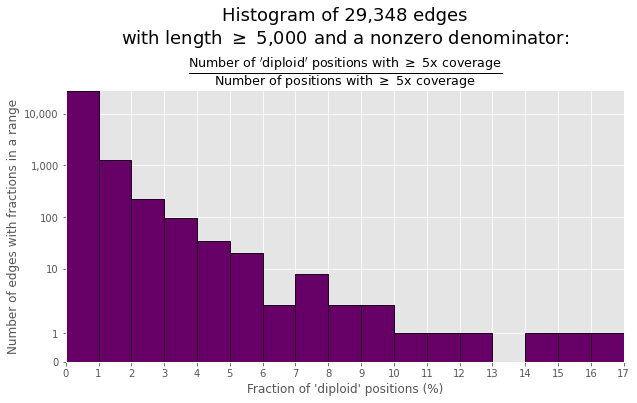

In [19]:
fracplot(
    edge2frac_diploid_to_mincov_positions,
    r"Number\ of\ positions\ with\ \geq\ 5x\ coverage",
    figfilename="prokeukfrac_den_mincov.png"
)

28,553 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78462); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_73159', 'edge_73227', 'edge_75050', 'edge_75973', 'edge_76875', 'edge_77432', 'edge_77766', 'edge_77962', 'edge_78457', 'edge_78462']
Bottom 10 edges: ['edge_8', 'edge_12', 'edge_14', 'edge_24', 'edge_34', 'edge_37', 'edge_38', 'edge_42', 'edge_46', 'edge_48']


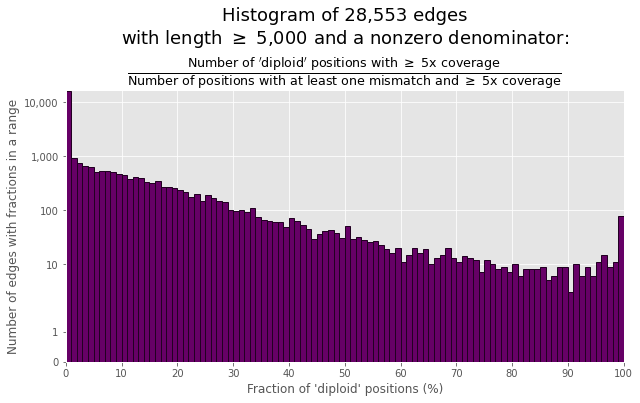

In [20]:
fracplot(
    edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch,
    r"Number\ of\ positions\ with\ at\ least\ one\ mismatch\ and\ \geq\ 5x\ coverage",
    figfilename="prokeukfrac_den_mincov_and_atleast_one_mm.png"
)

27,241 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78462); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_72261', 'edge_72309', 'edge_72350', 'edge_72388', 'edge_72452', 'edge_73227', 'edge_75050', 'edge_77766', 'edge_77962', 'edge_78462']
Bottom 10 edges: ['edge_8', 'edge_12', 'edge_14', 'edge_24', 'edge_34', 'edge_37', 'edge_38', 'edge_42', 'edge_46', 'edge_48']


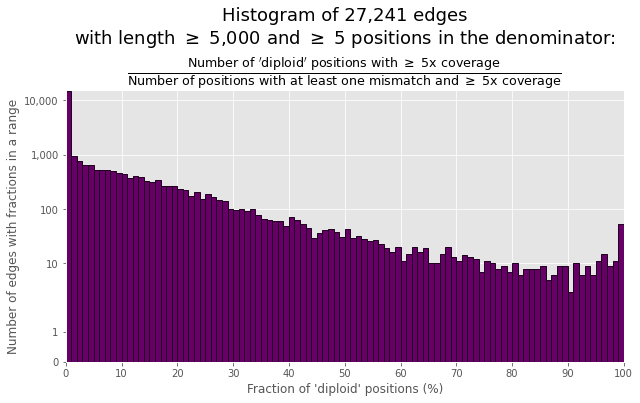

In [21]:
fracplot(
    edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5,
    r"Number\ of\ positions\ with\ at\ least\ one\ mismatch\ and\ \geq\ 5x\ coverage",
    denclause=" and $\geq$ 5 positions in the denominator",
    figfilename="prokeukfrac_den_mincov_and_atleast_one_mm_den_geq_5_pos.png"
)

27,960 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78779); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_76890', 'edge_77432', 'edge_77713', 'edge_77766', 'edge_77962', 'edge_78010', 'edge_78457', 'edge_78462', 'edge_78770', 'edge_78779']
Bottom 10 edges: ['edge_8', 'edge_12', 'edge_14', 'edge_24', 'edge_34', 'edge_37', 'edge_38', 'edge_42', 'edge_46', 'edge_48']


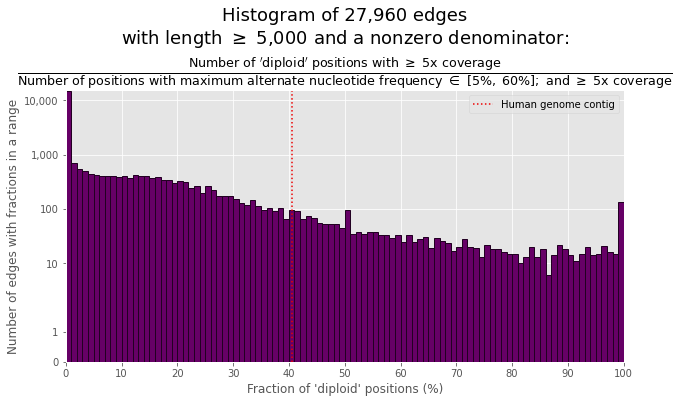

In [35]:
fracplot(
    edge2frac_diploid_to_mincov_positions_in_denominator_range,
    r"Number\ of\ positions\ with\ maximum\ alternate\ nucleotide\ frequency\ \in\ [5\%,\ 60\%];\ and\ \geq\ 5x\ coverage",
    figfilename="prokeukfrac_newden.png",
    vlines=[(57665 / 141922, "Human genome contig")]
)

25,989 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78779); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_75012', 'edge_75050', 'edge_75500', 'edge_75992', 'edge_76641', 'edge_76890', 'edge_77766', 'edge_77962', 'edge_78462', 'edge_78779']
Bottom 10 edges: ['edge_8', 'edge_12', 'edge_14', 'edge_24', 'edge_34', 'edge_37', 'edge_38', 'edge_42', 'edge_46', 'edge_48']


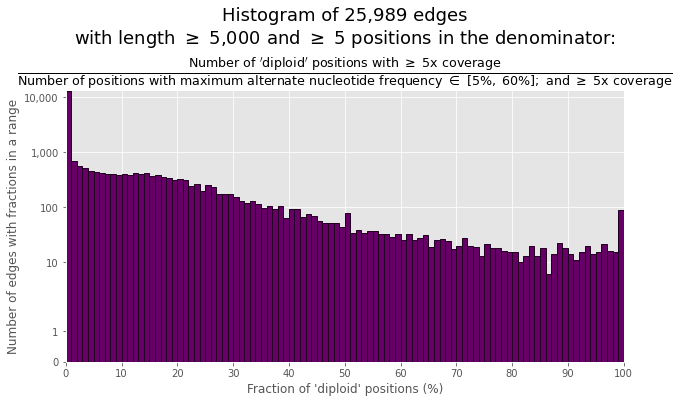

In [23]:
fracplot(
    edge2frac_diploid_to_mincov_positions_in_denominator_range_only_if_den_geq5,
    r"Number\ of\ positions\ with\ maximum\ alternate\ nucleotide\ frequency\ \in\ [5\%,\ 60\%];\ and\ \geq\ 5x\ coverage",
    figfilename="prokeukfrac_newden_den_geq_5_pos.png",
    denclause=" and $\geq$ 5 positions in the denominator",
)

In [13]:
def estats(e):
    num_dip = edge2num_mincov_putatively_diploid_positions[e]
    num_1mm = edge2num_mincov_positions_with_at_least_one_mismatch[e]
    num_den = edge2num_mincov_positions_with_mutrate_in_denominator_range[e]
    num_mcp = edge2num_mincov_positions[e]
    print("=" * 79)
    print(f"Edge {e} ({edge2len[e]:,} bp long) has ...")
    print(f"{num_mcp:,} min-cov'd positions.")
    print(f"{num_1mm:,} min-cov'd positions with at least one mismatch.")
    print(f"{num_den:,} min-cov'd positions with mut rates in den range.")
    print(f"{num_dip:,} 'diploid' min-cov'd positions.")
    try:
        print(f"Frac of mincov diploid to total mincov: {edge2frac_diploid_to_mincov_positions[e]}")
        print(f"Frac of mincov diploid to mincov'd with mut rates in den range: {edge2frac_diploid_to_mincov_positions_in_denominator_range[e]}")
        print(f"Frac of mincov diploid to mincov'd with at least one mismatch: {edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch[e]}")
        print(f"Frac of mincov diploid to mincov'd with at least one mismatch,\n    limited to if there are >= 5 such denominator positions: {edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5[e]}")
    except KeyError:
        print(f"(Looks like this edge doesn't have all fractions defined for it.)")
        pass

In [14]:
estats("edge_17771")
estats("edge_71904")
estats("edge_66025")
estats("edge_78689")
estats("edge_78501")
estats("edge_78779")
# example of an edge where we probs shouldn't care much about it, since it only has 1 min-cov'd position
# with at least one mismatch (so although its fraction for the second plot is 100%, it's probs
# not super interesting)
estats("edge_2987")
# from BLASTing this, seems like it might be a bacteria?
estats("edge_4916")

Edge edge_17771 (14,607 bp long) has ...
6,777 min-cov'd positions.
22 min-cov'd positions with at least one mismatch.
22 min-cov'd positions with mut rates in den range.
22 'diploid' min-cov'd positions.
Frac of mincov diploid to total mincov: 0.003246274162608824
Frac of mincov diploid to mincov'd with mut rates in den range: 1.0
Frac of mincov diploid to mincov'd with at least one mismatch: 1.0
Frac of mincov diploid to mincov'd with at least one mismatch,
    limited to if there are >= 5 such denominator positions: 1.0
Edge edge_71904 (34,872 bp long) has ...
3,827 min-cov'd positions.
479 min-cov'd positions with at least one mismatch.
414 min-cov'd positions with mut rates in den range.
396 'diploid' min-cov'd positions.
Frac of mincov diploid to total mincov: 0.10347530702900444
Frac of mincov diploid to mincov'd with mut rates in den range: 0.9565217391304348
Frac of mincov diploid to mincov'd with at least one mismatch: 0.826722338204593
Frac of mincov diploid to mincov'd with

## Go through some of the highest-fraction edges and retrieve their sequences in a FASTA file

So we can BLAST them, to get a sense for if they might actually correspond to sequences from eukaryotic organisms.

In [15]:
# I just copied these lists from the "top N" output printed from the fracplot() function, but I could also
# totally things up so that these are automatically computed
edges_to_fetch = set(
    ['edge_44228', 'edge_61346', 'edge_56298', 'edge_28715', 'edge_38218', 'edge_72103', 'edge_71715', 'edge_4916', 'edge_71904', 'edge_66025'] +
    ['edge_76890', 'edge_77432', 'edge_77713', 'edge_77766', 'edge_77962', 'edge_78010', 'edge_78457', 'edge_78462', 'edge_78770', 'edge_78779']
)
print(f"Trying to fetch {len(edges_to_fetch)} edge sequences.")
out_fasta = ""
with open("../main-workflow/output/all_edges.fasta", "r") as fastafile:
    
    # Assumes that sequences are not split up over multiple lines (so a FASTA file with N sequences
    # should have only 2N lines, maybe 2N + 1 if there's an extra empty newline at the bottom of the file)
    for linenum, line in enumerate(fastafile):
    
        if line.startswith(">"):
            if linenum % 2 != 0:
                raise ValueError("something weird with > location in all_edges.fasta. Go yell at Marcus.")
            edgename = line.strip()[1:]
        else:
            if linenum % 2 != 1:
                raise ValueError("something weird with non > location in all_edges.fasta. Go yell at Marcus.")
            if edgename is None:
                raise ValueError("No sequence name set yet?")
            if edgename in edges_to_fetch:
                seq = line.strip()
                out_fasta += f">{edgename}\n{seq}\n"
            edgename = None

with open("misc-output/potentially_euk_edges.fasta", "w") as eukfile:
    eukfile.write(out_fasta)

print("Done!")

Trying to fetch 20 edge sequences.
Done!


## Pick five low-fraction and five high-fraction sequences; plot histograms of all their mutation rates

In [12]:
# Three selected bacterial MAGs used in the rare mutation report, plus two edges for which the fraction
# where the denominator is # positions with mut rates in [5%, 60%] is especially low
probs_prok_seqs_to_check = ["edge_6104", "edge_1671", "edge_2358", "edge_8", "edge_12"]
# Some edges with esp high fractions from the first fraction (diploid / mincov) and another fraction
# (diploid / [5%, 60%])
probs_euk_seqs_to_check = ["edge_71904", "edge_66025", "edge_78462", "edge_78770", "edge_78779"]

In [ ]:
seq2mincov_pos_mutation_rates = {}
for seq in (probs_euk_seqs_to_check + probs_prok_seqs_to_check):
    
    meancov = edge2meancov[seq]
    min_wc_cov = max(meancov - (meancov * COV_DEVIATION), 1)
    
    print(f"On seq {seq} (length {edge2len[seq]:,} bp, meancov = {meancov:,.2f}x, min wc cov = {min_wc_cov:,.2f}x).", end=" ")
    
    seq2mincov_pos_mutation_rates[seq] = []
    
    lenfrac = math.floor(edge2len[seq] / 50)
    
    # Same pileup iteration as above
    for ri, rec in enumerate(
        pysamstats.stat_variation(
            bf, chrom=seq, fafile="../main-workflow/output/all_edges.fasta", start=0, end=edge2len[seq],
            truncate=True, pad=True, max_depth=1e6
        ),
        1
    ):
        # very simple progress bar for my own sake. might miss a few dots here and there.
        # more granularity since fewer seqs
        if ri % lenfrac == 0:
            print("*", end="", flush=True)
            
        matches = rec["matches"]
        mismatches = rec["mismatches"]
        cov = matches + mismatches
        
        if cov >= min_wc_cov:
            _, _, f = get_mutation_freq(rec)
            seq2mincov_pos_mutation_rates[seq].append(f)
             
    assert ri == edge2len[seq]
    print("")

On seq edge_71904 (length 34,872 bp, meancov = 2.78x, min wc cov = 2.23x). **************************************************
On seq edge_66025 (length 13,937 bp, meancov = 6.80x, min wc cov = 5.44x). **************************************************
On seq edge_78462 (length 15,785 bp, meancov = 2.43x, min wc cov = 1.94x). **************************************************
On seq edge_78770 (length 17,161 bp, meancov = 304.35x, min wc cov = 243.48x). **************************************************
On seq edge_78779 (length 12,353 bp, meancov = 55.93x, min wc cov = 44.74x). **************************************************
On seq edge_6104 (length 1,289,244 bp, meancov = 4,158.96x, min wc cov = 3,327.17x). ********

### Save this JSON data to a new file / Load it from that file so we can avoid redoing the above step if needed

(...because this data takes like 30 minutes to generate, and I don't want to have to melt an iceberg every time I want to change a color in one of these plots...)

In [ ]:
with open("misc-output/seq2mincov_pos_mutation_rates.json", "w") as jf:
    jf.write(json.dumps(seq2mincov_pos_mutation_rates))

In [9]:
with open("misc-output/seq2mincov_pos_mutation_rates.json", "r") as jf:
    seq2mincov_pos_mutation_rates = json.load(jf)

In [16]:
def seq_mutrate_hist(ax, mut_rates):
    """Actually visualizes a histogram of mutation rates for a given sequence.
    
    ax should be a matplotlib Axes object -- the plot will be drawn here (useful if we wanna draw
    a bunch of these plots in the same Figure).
    
    mut_rates should contain numbers in the range [0, 1]. These'll be automatically converted to percentages.
    """
    binsize = 1
    # one bin per (binsize)%
    bins = range(0, 101, binsize)
    _, _, patches = ax.hist(
        [f * 100 for f in mut_rates],
        bins=bins,
        color="#660066",
        linewidth=1,
        edgecolor="#220022",
    )
    ax.set_ylim(0)
    ax.set_xlim(0, 50)
    ax.set_yscale("symlog") 
    use_thousands_sep(ax.yaxis)

    ax.axvline(40, color="#8888dd", linestyle="--")

    # Make bins >= 40% a different color: https://stackoverflow.com/a/49290555
    for patch in patches[40:]:
        patch.set_facecolor("#8888dd")

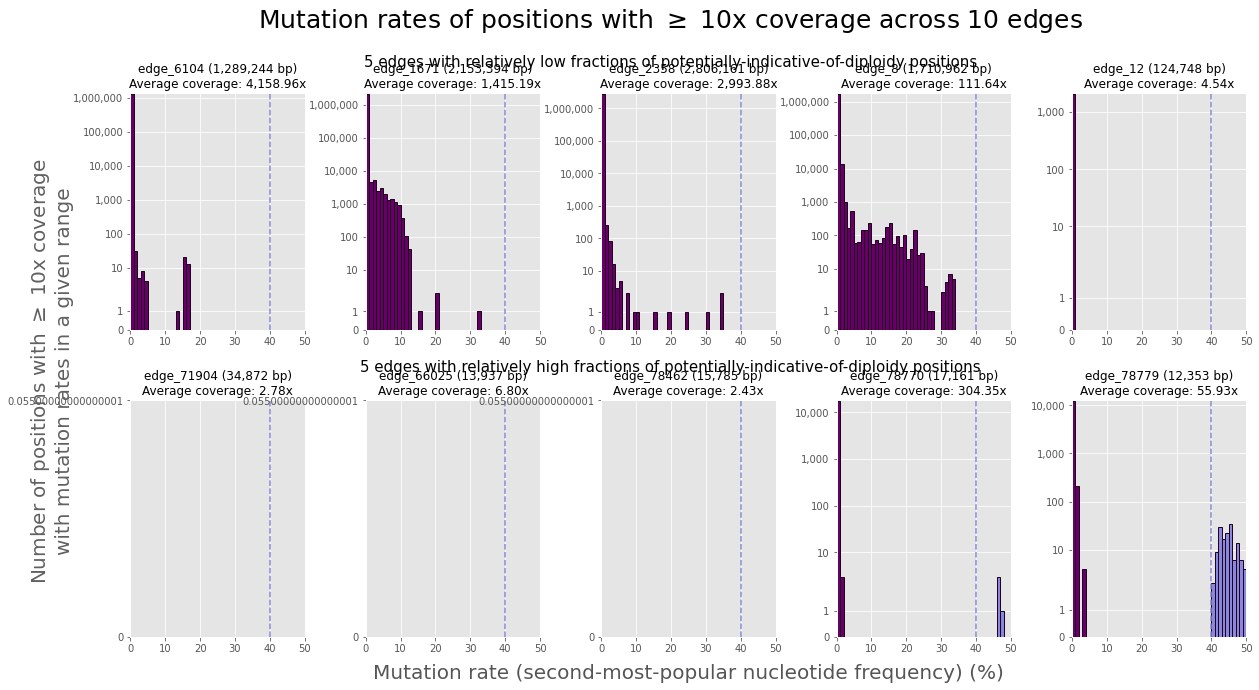

In [17]:
fig, axes = pyplot.subplots(2, 5, gridspec_kw={"wspace": 0.35, "hspace": 0.5})

rows = [probs_prok_seqs_to_check, probs_euk_seqs_to_check]
for ri, row in enumerate(rows):
    for ci, seq in enumerate(row):
        mut_rates = seq2mincov_pos_mutation_rates[seq]
        seq_mutrate_hist(axes[ri, ci], mut_rates)
        axes[ri, ci].set_title(f"{seq} ({edge2len[seq]:,} bp)\nAverage coverage: {edge2meancov[seq]:,.2f}x", fontsize=12)

axes[1, 2].set_xlabel("Mutation rate (second-most-popular nucleotide frequency) (%)", fontsize=20, labelpad=10)
        
num_plotted_edges = sum([len(r) for r in rows])
# We move up the suptitle's y from 0.98 (default) as a very crude way to force the plot to have
# more space between this title and the row 1 title.
fig.suptitle(
    f"Mutation rates of well-covered positions across {num_plotted_edges} edges",
    y=1,
    fontsize=25
)

# y-axis label: centered on the left side of the figure
fig.text(
    0.07, 0.495,
    f"Number of well-covered positions\nwith mutation rates in a given range",
    color="#606060",
    fontsize=20,
    rotation=90,
    va="center",
    ha="center"
)
# Title for row 1. The y=0.923 here is because this is figure coordinates, so this is "close to the top
# of the plot".
fig.text(
    0.5, 0.923,
    '5 edges with relatively low fractions of potentially-indicative-of-diploidy positions',
    fontsize=15,
    ha="center",
    va="center"
)
# Title for row 2.
fig.text(
    0.5, 0.5,
    '5 edges with relatively high fractions of potentially-indicative-of-diploidy positions',
    fontsize=15,
    ha="center",
    va="center"
)
fig.set_size_inches(20, 10)
fig.savefig("figs/prokeuk_10_mutrate_histograms.png", bbox_inches="tight")

## Similar mutation-rate visualization, but for a contig from a human genome assembly

In [6]:
# NOTE: This is a huge file, if this needs to be adapted into a pipeline or something this should be modified
# so that the file is read line-by-line or something rather than all at once
with open("../../hifiasm-hg002/output/h1tg000001l-mincov-pos-mutation-rates.json", "r") as hf:
    h_mut_rates = json.load(hf)["h1tg000001l"]
    
print(f"There are {len(h_mut_rates):,} positions described in this file.")

There are 101,325,796 positions described in this file.


In [9]:
h_contig_len = len(skbio.DNA.read("../../hifiasm-hg002/h1tg000001l.fasta"))
print(f"Contig has length {h_contig_len:,} bp.")

Contig has length 101,329,166 bp.


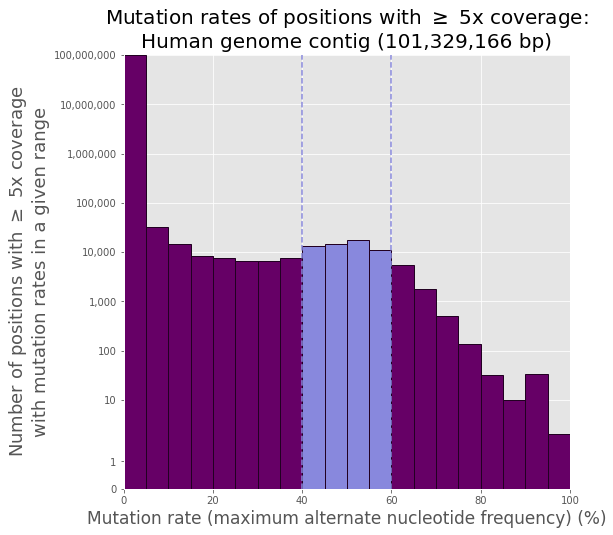

In [35]:
fig, ax = pyplot.subplots(1)

seq_mutrate_hist(ax, h_mut_rates)

ax.set_title(f"Mutation rates of positions with $\geq$ {MIN_COV}x coverage:\nHuman genome contig ({h_contig_len:,} bp)", fontsize=20)
ax.set_xlabel("Mutation rate (maximum alternate nucleotide frequency) (%)", fontsize=17)
ax.set_ylabel(f"Number of positions with $\geq$ {MIN_COV}x coverage\nwith mutation rates in a given range", fontsize=18)

fig.set_size_inches(8, 8)
fig.savefig("figs/prokeuk_hcontig_mutrate_histogram.png", bbox_inches="tight")

In [42]:
num_h_diploid_mincov = 0
num_h_btwn_5_60_mincov = 0
num_h_btwn_3_50_mincov = 0
for mr in h_mut_rates:
    if mr >= MIN_DIPLOID_MAXALT_FREQ and mr <= MAX_DIPLOID_MAXALT_FREQ:
        num_h_diploid_mincov += 1
    if mr >= MIN_DENOMINATOR_MAXALT_FREQ and mr <= MAX_DENOMINATOR_MAXALT_FREQ:
        num_h_btwn_5_60_mincov += 1
    if mr >= 0.03 and mr <= 0.5:
        num_h_btwn_3_50_mincov += 1
        
print(f"H. contig has {num_h_diploid_mincov:,} putatively diploid positions with cov >= {MIN_COV}x.")
print(f"H. contig has {num_h_btwn_5_60_mincov:,} positions with mut rates in [5%, 60%] with cov >= {MIN_COV}x.")
print(f"H. contig has {num_h_btwn_3_50_mincov:,} positions with mut rates in [3%, 50%] with cov >= {MIN_COV}x.")

print("=" * 79)
f =  100 * (num_h_diploid_mincov / num_h_btwn_5_60_mincov)
f2 = 100 * (num_h_diploid_mincov / num_h_btwn_3_50_mincov)
print(f"So the fraction,  using the denominator as the [5%, 60%] positions, is {f:.2f}%.")
print(f"And the fraction, using the denominator as the [3%, 50%] positions, is {f2:.2f}%.")

H. contig has 57,665 putatively diploid positions with cov >= 5x.
H. contig has 141,922 positions with mut rates in [5%, 60%] with cov >= 5x.
H. contig has 249,064 positions with mut rates in [3%, 50%] with cov >= 5x.
So the fraction,  using the denominator as the [5%, 60%] positions, is 40.63%.
And the fraction, using the denominator as the [3%, 50%] positions, is 23.15%.
